In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Setting up the TPUs and Importing Libraries**

In [2]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

2022-10-31 13:44:34.217107: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-31 13:44:34.217272: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-31 13:44:40.278178: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-31 13:44:40.282245: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-10-31 13:44:40.282328: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-31 13:44:40.282361: I tensorflow/stream_executor/cuda/cud

Device: grpc://10.0.0.2:8470
Number of replicas: 8


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

# **Loading the Data**

In [5]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

### Count of images from each class

In [6]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349


2022-10-31 13:46:11.336469: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 10485, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667223971.333131204","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 10485, Output num: 0","grpc_status":3}


Pneumonia images count in training set: 3883


### Preparing the Data

In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [8]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

In [9]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


2022-10-31 13:48:52.220230: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 20981, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667224132.220161902","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 20981, Output num: 1","grpc_status":3}


In [10]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [11]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [12]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

# **Visualising the data**

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

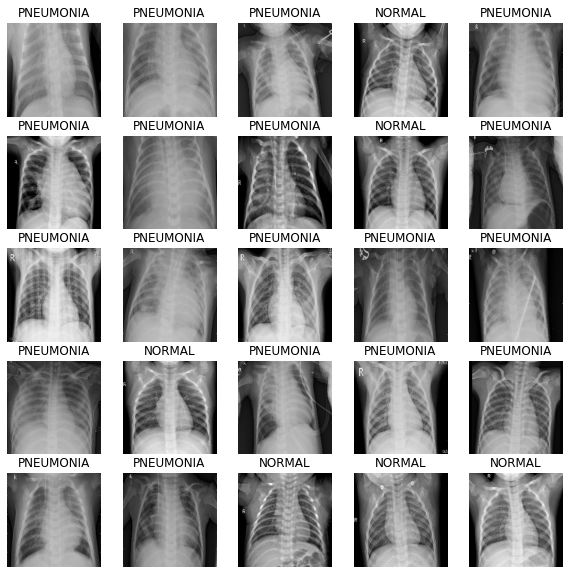

In [14]:
show_batch(image_batch.numpy(), label_batch.numpy())

# **Model Building**

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [21]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [22]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


In [23]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [24]:
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [25]:
with strategy.scope():
    model = build_model()

    METRICS = [
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
21/21 [==============================] - 25s 357ms/step - loss: 0.7816 - binary_accuracy: 0.6054 - precision: 0.8323 - recall: 0.5857 - val_loss: 0.5706 - val_binary_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000


2022-10-31 13:53:33.032114: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 26128, Output num: 2
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667224413.031460385","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 26128, Output num: 2","grpc_status":3}


Epoch 2/100
21/21 [==============================] - 2s 106ms/step - loss: 0.3473 - binary_accuracy: 0.8778 - precision: 0.9466 - recall: 0.8853 - val_loss: 0.6241 - val_binary_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 3/100
21/21 [==============================] - 2s 106ms/step - loss: 0.2475 - binary_accuracy: 0.9136 - precision: 0.9640 - recall: 0.9179 - val_loss: 2.8203 - val_binary_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 4/100
21/21 [==============================] - 2s 106ms/step - loss: 0.2128 - binary_accuracy: 0.9178 - precision: 0.9731 - recall: 0.9146 - val_loss: 1.8027 - val_binary_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 5/100
21/21 [==============================] - 2s 106ms/step - loss: 0.2079 - binary_accuracy: 0.9281 - precision: 0.9747 - recall: 0.9272 - val_loss: 4.3860 - val_binary_accuracy: 0.7471 - val_precision: 0.7471 - val_recall: 1.0000
Epoch 6/100
21/21 [=========================

# **Model Evaluation**

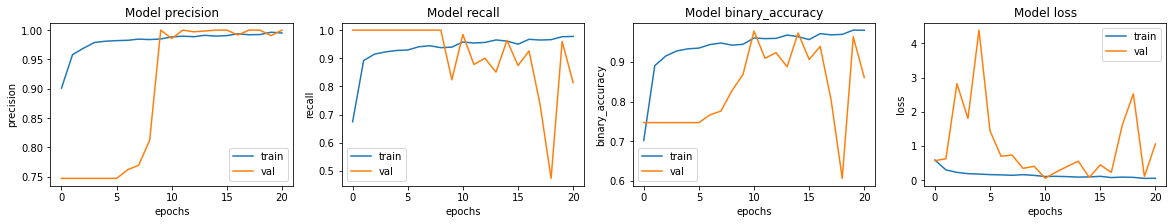

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

In [27]:
model.evaluate(test_ds, return_dict=True)

4/4 [==============================] - 4s 618ms/step - loss: 1.1226 - binary_accuracy: 0.7644 - precision: 0.7306 - recall: 0.9872


2022-10-31 13:54:37.261188: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 54858, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667224477.261093869","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 54858, Output num: 1","grpc_status":3}


{'loss': 1.1226392984390259,
 'binary_accuracy': 0.7644230723381042,
 'precision': 0.7305502891540527,
 'recall': 0.9871795177459717}

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  This is separate from the ipykernel package so we can avoid doing imports until
2022-10-31 13:56:00.260694: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 55220, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1667224560.260590293","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 55220, Output num: 0","grpc_status":3}


This image is 45.11 percent NORMAL
This image is 54.89 percent PNEUMONIA


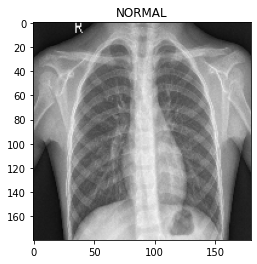

In [29]:
for image, label in test_ds.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))